# Term2 Sprint20

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行う。

今回は、転移学習を利用し、精度の向上を図る。

## Model architecture tuning & score optimization


Some ideas and code taken from ealier [kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras) and last prepared notebook.

Having dealt with data processing & engineering of channel features, next step of modeling is preparation and tuning of model architecture. Earlier notebooks provided a way to create images with three channels, which will facilitate usage of pretrained models.

For segmentation tasks, a pretrained model can be used as encoder part of the final architecture. 
In order to use pretrained models, we will have to extract features from a few intermediate layers, which will then serve as a basis for layers coming afterwards and for skip connections between encoder and decoder part.

ResNet50 is a good starting point, because it consists of 4 blocks, where each one of them can serve as feature extractor with first layer serving as the 5th extractor to achieve consistency with standard UNet architecture.

In [1]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !mkdir train
# !unzip /content/drive/'My Drive'/'Colab Notebooks'/kaggle_salt/train.zip
# !mv images train/images
# !mv masks train/

In [0]:
#!unzip /content/drive/'My Drive'/'Colab Notebooks'/kaggle_salt/test.zip -d test

In [0]:
# !cp /content/drive/'My Drive'/'Colab Notebooks'/kaggle_salt/sample_submission.csv /content/sample_submission.csv
# !cp /content/drive/'My Drive'/'Colab Notebooks'/kaggle_salt/train.csv /content/train.csv
# !cp /content/drive/'My Drive'/'Colab Notebooks'/kaggle_salt/depths.csv /content/depths.csv

In [0]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [0]:
pd.set_option('display.max_columns', 100)
def compute_coverage(df, masks):
    
    df = df.copy()  #trainのid,mask,depth情報
    
    #maskの含有率を整数クラスに置き換え
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2)) #y画像のマスク面積の比率を算出してクラス分け
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)
    print(df)

    return df


def create_depth_abs_channels(image_tensor):   #image_tensor= X_train_ch(4000,101,101,3)
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):  #0.01刻みのデータを生成
        image_tensor[row, :, 1] = const                         #1chの各行に0.01刻みのデータを代入
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])   #2chに0ch*1chのデータを代入

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)   #行方向の隣り合う要素同士の差分を計算
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)   #列方向の隣り合う要素同士の差分を計算
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0) #単一色の境界を追加
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0) #単一色の境界を追加
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

### Data loading & depth merge:

In [14]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/sample_submission.csv")
depth = pd.read_csv("/content/depths.csv")

train_src = '/content/train/'

print('train:\n{}'.format(train.head(20)))
print('\ntest:\n{}'.format(test.head(20)))
print('depths:\n{}'.format(depth.head(20)))

train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head(20)))

train:
            id                                           rle_mask
0   575d24d81d                                                NaN
1   a266a2a9df                                          5051 5151
2   75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3   34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4   4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
5   782ae9b7e7  1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
6   9842f69f8d                                                NaN
7   aa94cfb806  1 28 102 28 203 29 304 30 405 32 506 33 607 34...
8   50d3073821                                    1 2121 9293 909
9   28f865caaa                                                NaN
10  b5e1371b3b  75 27 175 28 275 29 374 31 474 32 574 33 674 3...
11  57e394bc67                                                NaN
12  b45ad3932e  49 11 149 11 249 11 351 10 452 9 553 9 654 8 7...
13  ef51bbcde7                                                NaN
14 

### Load images and masks, examine random sample:

In [16]:
#画像をグレースケールで読み込んでndarray配列に参照コピーし、０〜１のデータにならす。
X_train = np.asarray(
    [cv2.imread('/content/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread('/content/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape) #101x101x1チャンネルの画像4000枚

(4000, 101, 101) (4000, 101, 101)


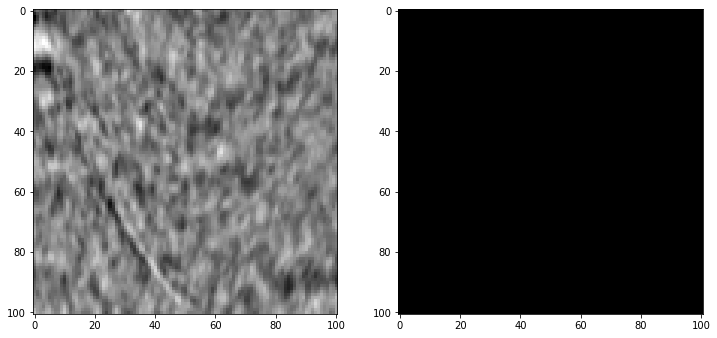

In [17]:
#変換した画像をランダムに表示してみる
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

### Compute salt coverage (this will serve as a basis for stratified split):

In [18]:
train = compute_coverage(train, y_train)

              id                                           rle_mask    z  \
0     575d24d81d                                                NaN  843   
1     a266a2a9df                                          5051 5151  794   
2     75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468   
3     34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727   
4     4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797   
...          ...                                                ...  ...   
3995  9cbd5ddba4                                                NaN  218   
3996  caa039b231  2398 7 2499 11 2600 16 2700 22 2801 26 2901 29...  602   
3997  1306fcee4c                                                NaN  177   
3998  48d81e93d9  2828 1 2927 3 3026 5 3126 6 3225 8 3324 10 342...  221   
3999  edf1e6ac00                                                NaN  460   

      coverage  coverage_class  
0     0.000000               0  
1     0.504950       

In [19]:
train.id.values

array(['575d24d81d', 'a266a2a9df', '75efad62c1', ..., '1306fcee4c',
       '48d81e93d9', 'edf1e6ac00'], dtype=object)

In [20]:
train.coverage_class.values.shape

(4000,)

### Prepare data for training:

In [21]:
kfold = StratifiedKFold(n_splits=5, random_state=1337) #データセットを５つに分割

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1) #(4000,101,101,1)>(4000,101,101,3)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))  #2chを特徴量エンジニアリング

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))
#print(X_resized[0:3])

for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):  #split(X, y)
    #train_index: trainデータのインデックス情報
    #y画像を数値化したもの（coverage_class）をyラベルとして代用している（0~10の多クラスとして擬似的に扱う）
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]

    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

(3196, 224, 224, 3) (3196, 224, 224, 1)
(804, 224, 224, 3) (804, 224, 224, 1)


0

### Loss functions & metric:

In [0]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

## ResNet50で学習・推定
### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers.
Default input size will be assumed, which is (224, 224, 3).
Layers will be as follows:

- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`.

In [35]:
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

### Decoder blocks:

Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed.
For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

In [0]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])   #入力のリスト同士を足し合わせる

    return x_dec2

### Model definition:

Combine encoder and decoder blocks to create final segmentation model.

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('activation_1').output   #(None, 112, 112, 64)
    encoder2 = base_model.get_layer('activation_10').output #(None, 56, 56, 256)
    encoder3 = base_model.get_layer('activation_22').output #(None, 28, 28, 512) 
    encoder4 = base_model.get_layer('activation_40').output #(None, 14, 14, 1024)
    encoder5 = base_model.get_layer('activation_49').output #(None, 7, 7, 2048)

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)  #(None, 7, 7, 512)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256) #(None, 7, 7, 256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1) #(None, 14, 14, 1280)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128) #(None, 14, 14, 128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1) #(None, 28, 28, 640)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64) #(None, 28, 28, 64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1) #(None, 56, 56, 320)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64) #(None, 56, 56, 64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1) #(None, 112, 112, 128)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1) #(None, 224, 224, 128)
    output = decoder_block(
        output, 'decoder_output', num_filters=32) #(None, 224, 224, 32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)  #(None, 224, 224, 1)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Inspect created model:

In [38]:
input_size = (224, 224, 3)


K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Train model:

In [39]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 50  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Validation set prediction and resizing to original size:

In [0]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization: 

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [42]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:36<00:00,  1.04s/it]


In [43]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.7578 at threshold: 0.840


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.752164
std,0.204939,0.004597
min,0.200000,0.742413
25%,0.370000,0.749565
50%,0.540000,0.752612
75%,0.710000,0.756032
max,0.880000,0.757836


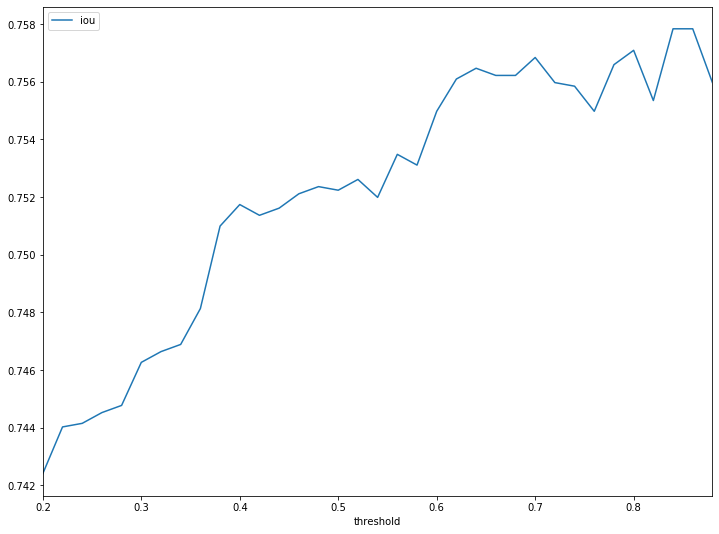

In [44]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

## コードリーディング

- 画像についての特徴量エンジニアリングを行なっている。具体的には、深度情報を擬似的に付加して学習させることで、スコアを若干改善している
- trainデータ分割のところで、yラベルを擬似的にクラス分けして、データが適切に分割されるよう調整している。
- 転移学習では、重みの固定は行わず、初期値として利用している。ImageNETの画像と地震探査画像が大きく異なる点がその理由と考えられる。
- UnetのDeConvolutionでは、プーリング前のデータを使用することで、特徴量情報をlossさせない工夫をしている。

## VGGで学習・推定

In [34]:
input_size = (224, 224, 3)

K.clear_session()
base_model = VGG16(input_shape=input_size, include_top=False)
for layer in base_model.layers[:10]:
    layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block1_conv2').output #(None, 224, 224, 64)
    encoder2 = base_model.get_layer('block2_conv2').output #(None, 112, 112, 128) 
    encoder3 = base_model.get_layer('block3_conv3').output  #(None, 56, 56, 256)
    encoder4 = base_model.get_layer('block4_conv3').output  #(None, 28, 28, 512) 
    encoder5 = base_model.get_layer('block5_conv3').output  #(None, 14, 14, 512)
    encoder6 = base_model.get_layer('block5_pool').output #(None, 7, 7, 512)

    # Center block
    center = decoder_block(
        encoder6, 'center', num_filters=128)
    concat6 = concatenate([center, encoder6], axis=-1) #(None, 7, 7, 640)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder5 = decoder_block(
        concat6, 'decoder5', num_filters=64) #(None, 7, 7, 256)
    concat5 = concatenate([UpSampling2D()(decoder5), encoder5], axis=-1) #(None, 14, 14, 576)

    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=64) #(None, 14, 14, 64) 
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1) #(None, 28, 28, 576)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=32) #(None, 28, 28, 32)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1) #(None, 56, 56, 288)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=16) #(None, 56, 56, 16)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1) #(None, 112, 112, 144)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=8) # (None, 112, 112, 8)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1) #(None, 224, 224, 72)

    # Final upsampling and decoder block for segmentation.
    #output = UpSampling2D()(concat1)
    output = decoder_block(
        concat1, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)

    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [26]:
#inspect created model
input_size = (224, 224, 3)

K.clear_session()
model = unet_vgg(
    input_size, decoder_block_simple, weights='imagenet')
for layer in base_model.layers[:10]:
    layer.trainable = False
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (Inp

### Train model

In [27]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
model_depth = unet_vgg(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_vgg.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 50  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv

### Validation set prediction and resizing to original size

In [0]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [30]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


In [31]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.6679 at threshold: 0.860


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.644350
std,0.204939,0.018035
min,0.200000,0.608831
25%,0.370000,0.633396
50%,0.540000,0.646891
75%,0.710000,0.659266
max,0.880000,0.667910


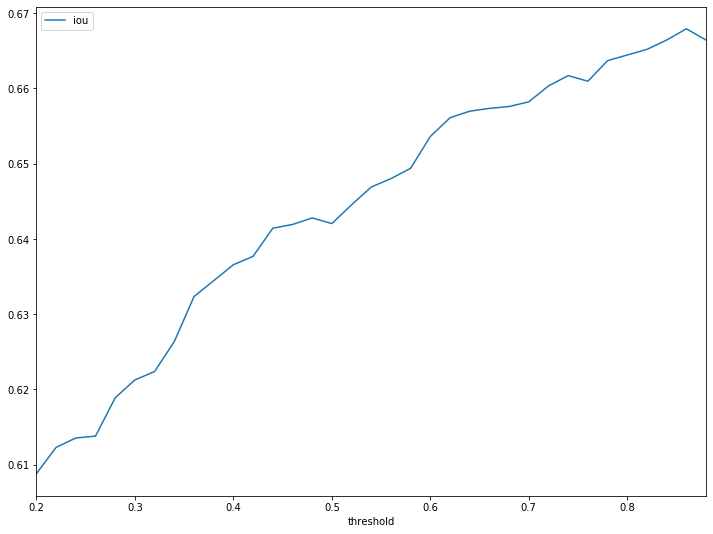

In [32]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

## ResNet50とVGGの結果比較
- ResNet50の方がスコアが良い（より豊かな表現に対応できる？）
- 処理速度についてはVGGの方がやや速いぐらい
